# Aesop's Filter

Aesop's Filter is a convolution based image filter for 0/1 binary image masks.

The filter uses a square kernel of user defined size.

The filter checks to see if a point and any point on a square drawn around the point are one's.

If there is a match then a line is drawn between the two individual points.

Otherwise if there is no match then the point is left out of the result.




### The effects of the filter are:
    * Bridging gaps between seperated points
    * Smoothing convex shapes
    * Closing holes
    * Removing small points
    

The filter was intended to aid in the generation of consistent masks for textural filters.

Currently all of the effects are applied concurrently.  With some modification it may be possible to isolate the effects.

In [1]:
# For Filter
import numpy as np
import cv2 as cv
from skimage.draw import line

# For Demonstrations
import matplotlib.pyplot as plt
from skimage.draw import disk
from sklearn.datasets import make_blobs

## Filter Definition

In [2]:
def aesops_Filter(image, kernel_size_start=3, kernel_size_end=3, kernel_step=2, series=False, steps=51):
    
    # Set up the resulting image
    
    result = np.zeros(image.shape, dtype='uint8')

    
    # Set the step size for increasing or decreasing kernel size
    
    if kernel_size_start > kernel_size_end:
        step = -kernel_step
        
    else:
        step = kernel_step
    
    
    # Iterate through the range of kernel sizes
    
    for i in range(kernel_size_start, kernel_size_end+1, step):
        

        
        # Set the end of the range index to be one less than the size 
        
        end = i - 1
        
        
        # Apply the filter to the horizontals, verticals and diagonals
        
        result = _apply_filter(result, image, 0, 0, end, 0)
        result = _apply_filter(result, image, 0, 0, 0, end)
        result = _apply_filter(result, image, 0, 0, end, end)
        result = _apply_filter(result, image, 0, end, end, 0)        
        
        steps_list = np.linspace(0, end, steps+1, dtype='uint8')
        steps_list = np.unique(steps_list)
        
            # Traverse the edges of the square
            
        for a in steps_list[1:]:
            result = _apply_filter(result, image, 0, 0, end, a)
            result = _apply_filter(result, image, end, 0, 0, a)
            result = _apply_filter(result, image, 0, 0, a, end)
            result = _apply_filter(result, image, 0, end, a, 0)

        if series == True :
            image = np.copy(result)
    
    return result

def _apply_filter(result, image, x1, y1, x2, y2):
    
    # Establish the temporary arrays
    
    temp_filtered = np.zeros(image.shape, dtype='uint8')
    temp_dilated = np.zeros(image.shape, dtype='uint8')
    
    
    # Set the dimensions for the kernel shape
    
    kx = np.abs(x2-x1) + 1
    ky = np.abs(y2-y1) + 1
    
    
    # Apply the filter checking for matching perimiter points

    kernel_filter = np.zeros((ky,kx), dtype='uint8')   
    kernel_filter [y1, x1] = 1
    kernel_filter [y2, x2] = 1
    
    temp_filtered = cv.filter2D( image, cv.CV_8U, kernel_filter, anchor=(x1, y1), borderType = cv.BORDER_CONSTANT|0)
    temp_filtered[temp_filtered<2] = 0
    
    
    # Apply the filter connecting matching perimiter points
    
    kernel_dil = np.zeros((ky,kx), dtype='uint8')
    lx, ly = line(x1, y1, x2, y2)
    kernel_dil[ ly, lx ] = 1
    
    temp_dilated = cv.dilate(temp_filtered, kernel_dil, anchor=(x2,y2), borderType = cv.BORDER_CONSTANT|0)
    temp_dilated[temp_dilated>0] = 1

    
    # Add the mask generated by the current iteration to the result
    
    result = np.maximum(result, temp_dilated)


    return result

## Demonstration Images Setup

In [3]:
def test_setup_diag(h_im=500, w_im=500, n_line=7):

    image = np.zeros((h_im, w_im), dtype='uint8')

    for i in range(n_line):
        x1 = 0
        x2 = w_im - 1

        y1 = i * ((( h_im-1) // (n_line - 1)) - 1) + i
        y2 = (h_im-1) - i * (h_im // (n_line - 1))

        lx, ly = line(x1, y1, x2, y2)
        image[ly, lx] = 1

        y1 = 0
        y2 = h_im - 1

        x1 = i * ((( w_im-1) // (n_line - 1)) - 1) + i
        x2 = (w_im-1) - i * (w_im // (n_line - 1))

        lx, ly = line(x1, y1, x2, y2)
        image[ly, lx] = 1

    
    return image

def add_blobs(img, n_samples=500000, n_components=35, cluster_std=0.6, random_state=0):
    
    
    h = img.shape[0]
    w = img.shape[1]
    
    X, y_true = make_blobs(n_samples=n_samples,
                           centers=n_components,
                           cluster_std=cluster_std,
                           random_state=random_state)

    X[:, 0] = X[:,0] - X[:,0].min()
    X[:, 0] = X[:,0] / X[:,0].max()
    X[:, 0] = (h - 1) * X[:, 0]

    X[:, 1] = X[:,1] - X[:,1].min()
    X[:, 1] = X[:,1] / X[:,1].max()
    X[:, 1] = (w-1) * X[:, 1]

    X = X.astype(np.int32)

    img[ X[:,0], X[:,1]] = 1
    
    return img

def add_circles(img, n_circles=100, size_min=1, size_max=50):
    
    y = np.random.randint(low=0, high=img.shape[0]-1, size=(n_circles), dtype=int)
    x = np.random.randint(low=0, high=img.shape[1]-1, size=(n_circles), dtype=int)
    radius = np.random.randint(low=size_min, high=size_max, size=(n_circles), dtype=int)
    
    for i in range(n_circles):
        
        rr, cc = disk((y[i], x[i]), radius[i], shape=img.shape)
        
        img[cc,rr] = 1
        
    return img
        

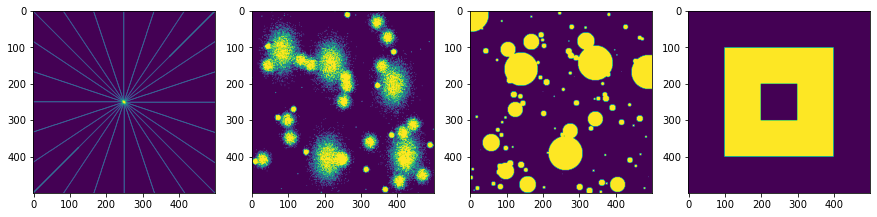

In [4]:
image = test_setup_diag(h_im=500, w_im=500, n_line=7);

image2 = np.zeros((500,500), dtype='uint8')

image2 = add_blobs(image2, n_samples = 50000, n_components = 35, cluster_std = 0.006, random_state = 5)
image2 = add_blobs(image2, n_samples = 50000, n_components = 12, cluster_std = 0.1, random_state = 10)
image2 = add_blobs(image2, n_samples = 50000, n_components = 20, cluster_std = 0.35, random_state = 20)
image2 = add_blobs(image2, n_samples = 50000, n_components = 5, cluster_std = 0.7, random_state = 40)

image3 = np.zeros((500,500), dtype='uint8')


image3 = add_circles(image3, n_circles=5, size_min=40, size_max=50)
image3 = add_circles(image3, n_circles=10, size_min=20, size_max=25)
image3 = add_circles(image3, n_circles=100, size_min=1, size_max=10)

image4 = np.zeros((500,500), dtype='uint8')

image4[100:400, 100:400] = 1
image4[200:300, 200:300] = 0

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image)
plt.subplot(1,4,2)
plt.imshow(image2)
plt.subplot(1,4,3)
plt.imshow(image3)
plt.subplot(1,4,4)
plt.imshow(image4)


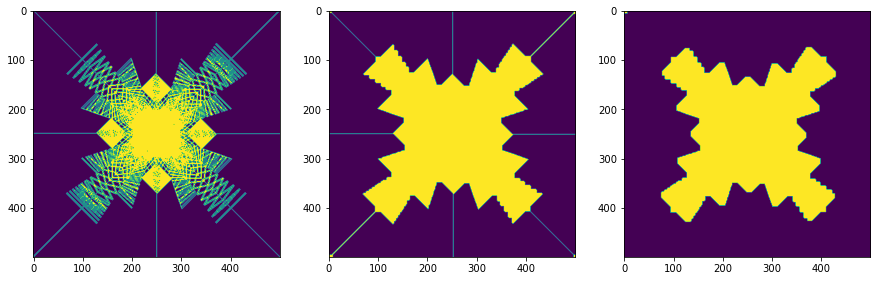

In [6]:
mask1 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=8)
mask2 = cv.morphologyEx( mask1, cv.MORPH_CLOSE, np.ones((10,10), dtype='uint8'))
mask3 = cv.morphologyEx( mask2, cv.MORPH_OPEN, np.ones((10,10), dtype='uint8'))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(mask1)
plt.subplot(1,3,2)
plt.imshow(mask2)
plt.subplot(1,3,3)
plt.imshow(mask3)

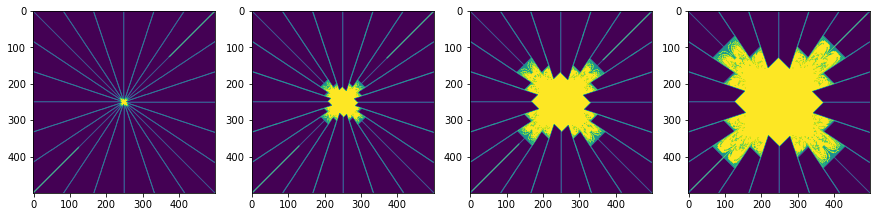

In [7]:
mask1 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=3, kernel_step=2, series=False, steps=51)
mask2 = aesops_Filter(image, kernel_size_start=11, kernel_size_end=11, kernel_step=2, series=False, steps=51)
mask3 = aesops_Filter(image, kernel_size_start=21, kernel_size_end=21, kernel_step=2, series=False, steps=51)
mask4 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=51)

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(mask1)
plt.subplot(1,4,2)
plt.imshow(mask2)
plt.subplot(1,4,3)
plt.imshow(mask3)
plt.subplot(1,4,4)
plt.imshow(mask4)

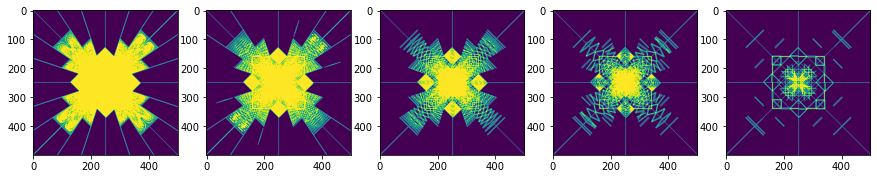

In [8]:
mask1 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=31)
mask2 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=16)
mask3 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=8)
mask4 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=4)
mask5 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=0)

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(mask1)
plt.subplot(1,5,2)
plt.imshow(mask2)
plt.subplot(1,5,3)
plt.imshow(mask3)
plt.subplot(1,5,4)
plt.imshow(mask4)
plt.subplot(1,5,5)
plt.imshow(mask5)

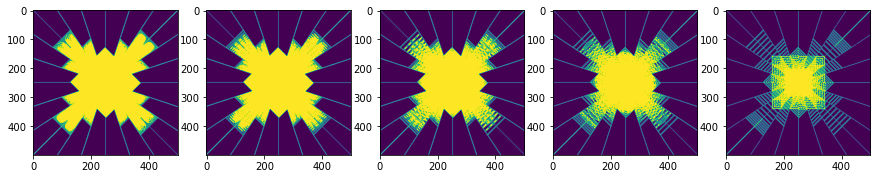

In [9]:
mask1 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=False, steps=31)
mask2 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=False, steps=16)
mask3 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=False, steps=8)
mask4 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=False, steps=4)
mask5 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=False, steps=0)

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(mask1)
plt.subplot(1,5,2)
plt.imshow(mask2)
plt.subplot(1,5,3)
plt.imshow(mask3)
plt.subplot(1,5,4)
plt.imshow(mask4)
plt.subplot(1,5,5)
plt.imshow(mask5)

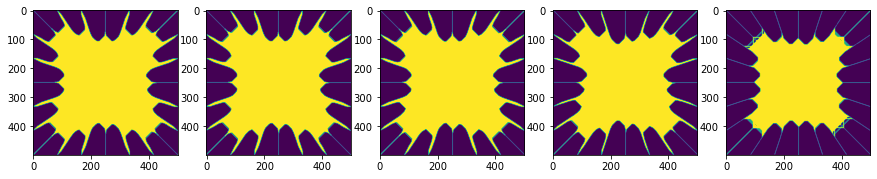

In [10]:
mask1 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=True, steps=31)
mask2 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=True, steps=16)
mask3 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=True, steps=8)
mask4 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=True, steps=4)
mask5 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=True, steps=0)

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(mask1)
plt.subplot(1,5,2)
plt.imshow(mask2)
plt.subplot(1,5,3)
plt.imshow(mask3)
plt.subplot(1,5,4)
plt.imshow(mask4)
plt.subplot(1,5,5)
plt.imshow(mask5)

In [11]:
%timeit mask1 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=True, steps=31)
%timeit mask2 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=True, steps=16)
%timeit mask3 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=True, steps=8)
%timeit mask4 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=True, steps=4)
%timeit mask5 = aesops_Filter(image, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=True, steps=0)

3.59 s ± 47.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.73 s ± 300 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.44 s ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
842 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
128 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


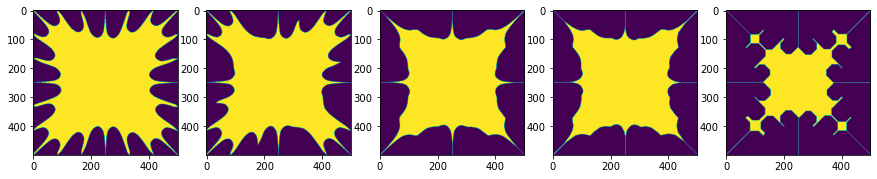

In [12]:
mask1 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=3, kernel_step=2, series=True, steps=31)
mask2 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=3, kernel_step=2, series=True, steps=16)
mask3 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=3, kernel_step=2, series=True, steps=8)
mask4 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=3, kernel_step=2, series=True, steps=4)
mask5 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=3, kernel_step=2, series=True, steps=0)

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(mask1)
plt.subplot(1,5,2)
plt.imshow(mask2)
plt.subplot(1,5,3)
plt.imshow(mask3)
plt.subplot(1,5,4)
plt.imshow(mask4)
plt.subplot(1,5,5)
plt.imshow(mask5)

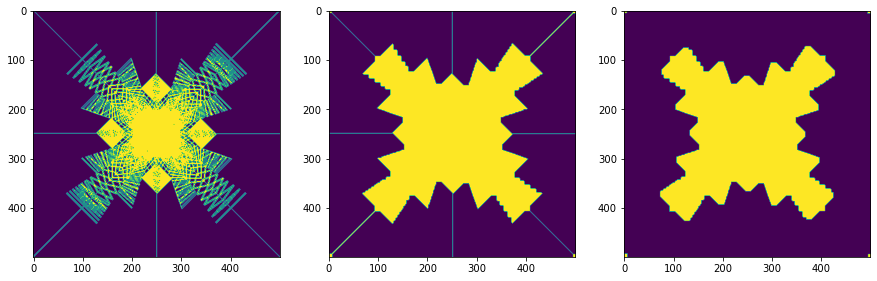

In [13]:
mask1 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=8)
mask2 = cv.morphologyEx( mask1, cv.MORPH_CLOSE, np.ones((11,11), dtype='uint8'))
mask3 = cv.morphologyEx( mask2, cv.MORPH_OPEN, np.ones((11,11), dtype='uint8'))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(mask1)
plt.subplot(1,3,2)
plt.imshow(mask2)
plt.subplot(1,3,3)
plt.imshow(mask3)

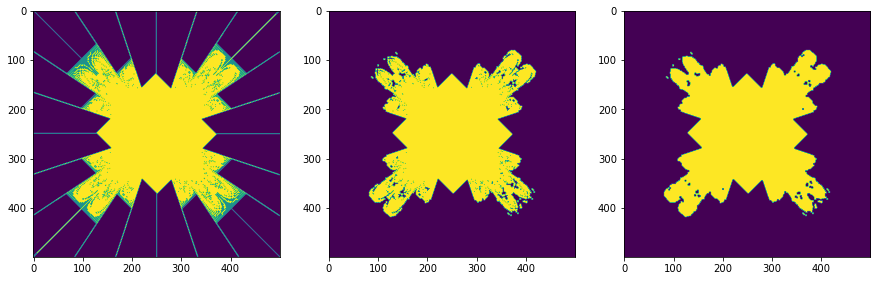

In [14]:
mask1 = aesops_Filter(image, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=31)
mask2 = cv.morphologyEx( mask1, cv.MORPH_OPEN, np.ones((3,3), dtype='uint8'))
mask3 = cv.morphologyEx( mask2, cv.MORPH_CLOSE, np.ones((3,3), dtype='uint8'))
mask4 = aesops_Filter(mask3, 31, 31)

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(mask1)
plt.subplot(1,3,2)
plt.imshow(mask2)
plt.subplot(1,3,3)
plt.imshow(mask3)

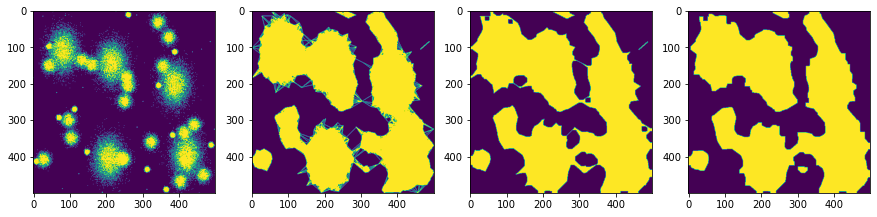

In [15]:
mask1 = aesops_Filter(image2, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=False, steps=8)
mask2 = cv.morphologyEx( mask1, cv.MORPH_CLOSE, np.ones((10,10), dtype='uint8'))
mask3 = cv.morphologyEx( mask2, cv.MORPH_OPEN, np.ones((10,10), dtype='uint8'))

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image2)
plt.subplot(1,4,2)
plt.imshow(mask1)
plt.subplot(1,4,3)
plt.imshow(mask2)
plt.subplot(1,4,4)
plt.imshow(mask3)



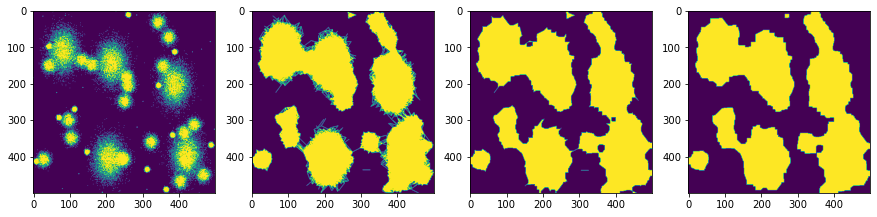

In [16]:
mask1 = aesops_Filter(image2, kernel_size_start=21, kernel_size_end=21, kernel_step=2, series=False, steps=8)
mask2 = cv.morphologyEx( mask1, cv.MORPH_CLOSE, np.ones((10,10), dtype='uint8'))
mask3 = cv.morphologyEx( mask2, cv.MORPH_OPEN, np.ones((10,10), dtype='uint8'))

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image2)
plt.subplot(1,4,2)
plt.imshow(mask1)
plt.subplot(1,4,3)
plt.imshow(mask2)
plt.subplot(1,4,4)
plt.imshow(mask3)


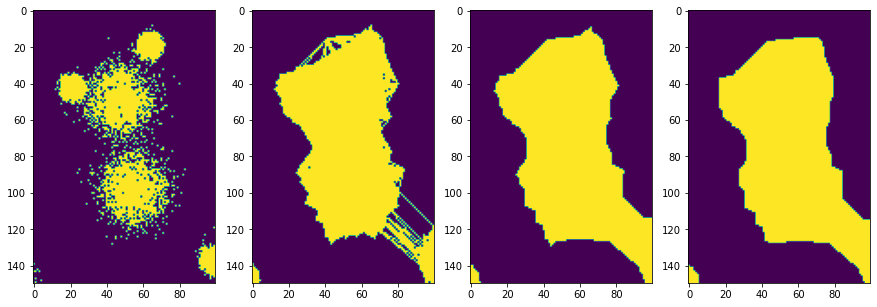

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image2[250:400, 50:150])
plt.subplot(1,4,2)
plt.imshow(mask1[250:400, 50:150])
plt.subplot(1,4,3)
plt.imshow(mask2[250:400, 50:150])
plt.subplot(1,4,4)
plt.imshow(mask3[250:400, 50:150])

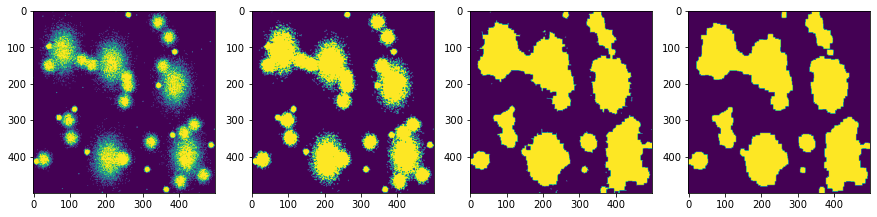

In [18]:
mask1 = aesops_Filter(image2, 3, 3)
mask2 = cv.morphologyEx( mask1, cv.MORPH_CLOSE, np.ones((10,10), dtype='uint8'))
mask3 = cv.morphologyEx( mask2, cv.MORPH_OPEN, np.ones((10,10), dtype='uint8'))

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image2)
plt.subplot(1,4,2)
plt.imshow(mask1)
plt.subplot(1,4,3)
plt.imshow(mask2)
plt.subplot(1,4,4)
plt.imshow(mask3)

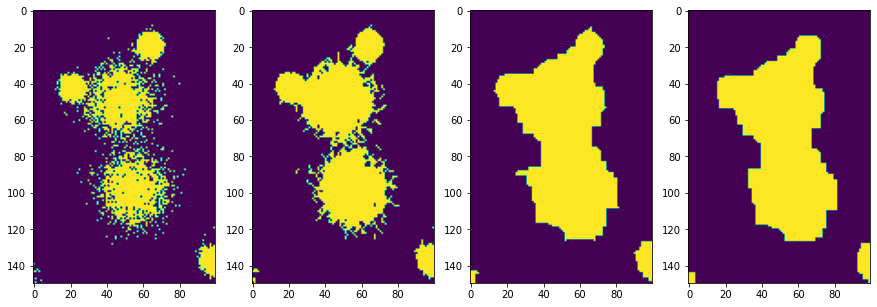

In [19]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image2[250:400, 50:150])
plt.subplot(1,4,2)
plt.imshow(mask1[250:400, 50:150])
plt.subplot(1,4,3)
plt.imshow(mask2[250:400, 50:150])
plt.subplot(1,4,4)
plt.imshow(mask3[250:400, 50:150])

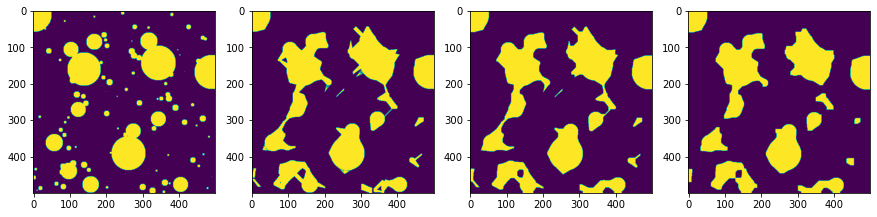

In [20]:
mask1 = aesops_Filter(image3, kernel_size_start=21, kernel_size_end=21, kernel_step=2, series=False, steps=8)
mask2 = cv.morphologyEx( mask1, cv.MORPH_CLOSE, np.ones((10,10), dtype='uint8'))
mask3 = cv.morphologyEx( mask2, cv.MORPH_OPEN, np.ones((10,10), dtype='uint8'))


plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image3)
plt.subplot(1,4,2)
plt.imshow(mask1)
plt.subplot(1,4,3)
plt.imshow(mask2)
plt.subplot(1,4,4)
plt.imshow(mask3)

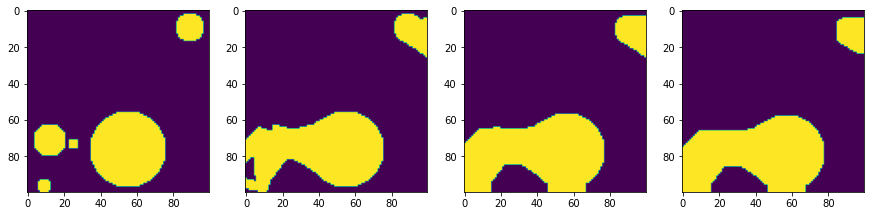

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image3[400:500, 350:450])
plt.subplot(1,4,2)
plt.imshow(mask1[400:500, 350:450])
plt.subplot(1,4,3)
plt.imshow(mask2[400:500, 350:450])
plt.subplot(1,4,4)
plt.imshow(mask3[400:500, 350:450])

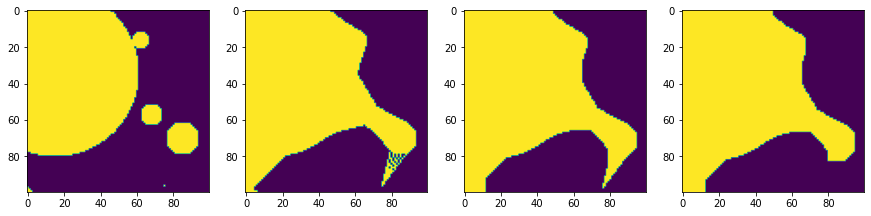

In [22]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image3[125:225, 125:225])
plt.subplot(1,4,2)
plt.imshow(mask1[125:225, 125:225])
plt.subplot(1,4,3)
plt.imshow(mask2[125:225, 125:225])
plt.subplot(1,4,4)
plt.imshow(mask3[125:225, 125:225])

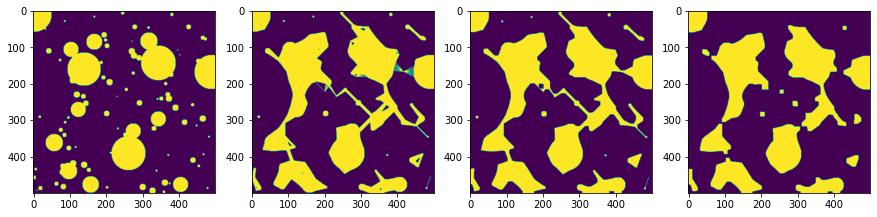

In [23]:
mask1 = aesops_Filter(image3, kernel_size_start=3, kernel_size_end=31, kernel_step=2, series=False, steps=8)
mask2 = cv.morphologyEx( mask1, cv.MORPH_CLOSE, np.ones((10,10), dtype='uint8'))
mask3 = cv.morphologyEx( mask2, cv.MORPH_OPEN, np.ones((10,10), dtype='uint8'))


plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image3)
plt.subplot(1,4,2)
plt.imshow(mask1)
plt.subplot(1,4,3)
plt.imshow(mask2)
plt.subplot(1,4,4)
plt.imshow(mask3)

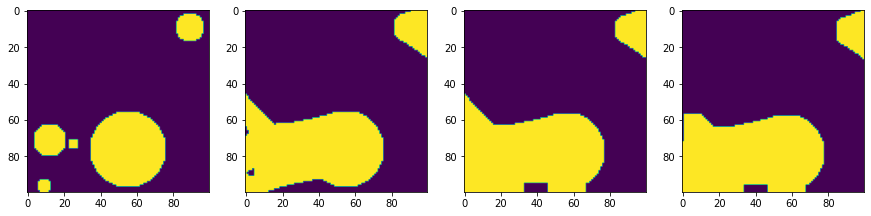

In [24]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image3[400:500, 350:450])
plt.subplot(1,4,2)
plt.imshow(mask1[400:500, 350:450])
plt.subplot(1,4,3)
plt.imshow(mask2[400:500, 350:450])
plt.subplot(1,4,4)
plt.imshow(mask3[400:500, 350:450])

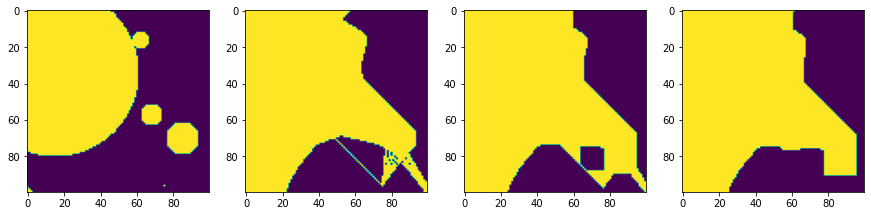

In [25]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image3[125:225, 125:225])
plt.subplot(1,4,2)
plt.imshow(mask1[125:225, 125:225])
plt.subplot(1,4,3)
plt.imshow(mask2[125:225, 125:225])
plt.subplot(1,4,4)
plt.imshow(mask3[125:225, 125:225])

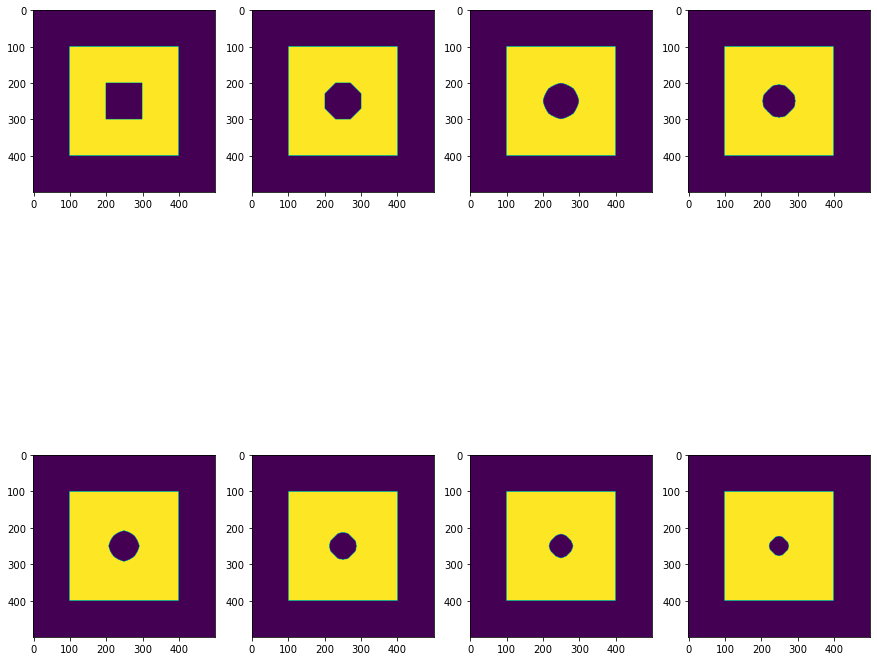

In [26]:
mask1 = aesops_Filter(image4, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=31)
mask2 = aesops_Filter(mask1, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=31)
mask3 = aesops_Filter(mask2, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=31)
mask4 = aesops_Filter(mask3, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=31)
mask5 = aesops_Filter(mask4, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=31)
mask6 = aesops_Filter(mask5, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=31)
mask7 = aesops_Filter(mask6, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=31)

plt.figure(figsize=(15,15))
plt.subplot(2,4,1)
plt.imshow(image4)
plt.subplot(2,4,2)
plt.imshow(mask1)
plt.subplot(2,4,3)
plt.imshow(mask2)
plt.subplot(2,4,4)
plt.imshow(mask3)
plt.subplot(2,4,5)
plt.imshow(mask4)
plt.subplot(2,4,6)
plt.imshow(mask5)
plt.subplot(2,4,7)
plt.imshow(mask6)
plt.subplot(2,4,8)
plt.imshow(mask7)

In [27]:
from aesop import aesop

In [32]:
mask = aesop.aesops_Filter(image2, kernel_size_start=31, kernel_size_end=31, kernel_step=2, series=False, steps=31)

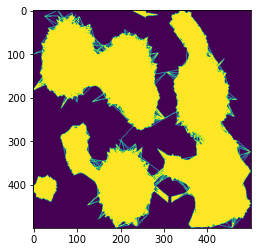

In [33]:
plt.imshow(mask)